In [1]:
#import libraries
import xgboost as xg
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, KFold, GridSearchCV, cross_val_predict
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization, LeakyReLU
from sklearn.metrics import r2_score
import data_ML as ML
import pickle
from keras.models import load_model
from tqdm import tqdm
from sklearn.pipeline import Pipeline



np.set_printoptions(suppress=True)

In [2]:
df = ML.getdata(True)

def modifydata(df):
    data_calls = []
    data_puts = []
    df_puts = df[df.optionType == 0].drop(columns='optionType')
    df_calls = df[df.optionType == 1].drop(columns='optionType')
    df_american_calls = df_calls[df_calls.method == 1].drop(columns='method')
    df_american_puts = df_puts[df_puts.method == 1].drop(columns='method')
    df_american_calls = df_american_calls.drop(columns='index')
    df_american_calls = df_american_calls[df_american_calls.lastPrice > 5]
    df_american_puts = df_american_puts[df_american_puts.lastPrice > 5]
    df_american_puts = df_american_puts.drop(columns='index')
    y_calls = np.asarray(df_american_calls[['lastPrice']])
    y_puts = np.asarray(df_american_puts[['lastPrice']])
    df_american_calls = df_american_calls.drop(columns='lastPrice')
    df_american_puts = df_american_puts.drop(columns='lastPrice')

    for line in range(len(df_american_calls)):
        data_tmp = df_american_calls.iloc[line]
        data_calls.append(data_tmp)
    data_calls = np.asarray(data_calls)


    for line in range(len(df_american_puts)):
        data_tmp = df_american_puts.iloc[line]
        data_puts.append(data_tmp)
    data_puts = np.asarray(data_puts)

    return data_calls, data_puts, y_calls, y_puts

TimeoutError: [Errno 60] Operation timed out

In [220]:
X_calls, X_puts, y_calls, y_puts = modifydata(df)
X_train_calls, X_test_calls, y_train_calls, y_test_calls = train_test_split(X_calls, y_calls, test_size=0.25)
X_train_puts, X_test_puts, y_train_puts, y_test_puts = train_test_split(X_puts, y_puts, test_size=0.25)

In [221]:
print(X_test_calls.shape)
print(X_train_calls.shape)
print(X_test_puts.shape)
print(X_train_puts.shape)

(9063, 5)
(27187, 5)
(6065, 5)
(18194, 5)


# Pipeline optimization

In [222]:
def model(pipeline, parameters, X_train, y_train, X, y, figname):
    grid_obj = GridSearchCV(estimator = pipeline, param_grid = parameters, cv = 5, scoring = 'r2', verbose = 0, n_jobs = 1, refit = True)
    grid_obj.fit(X_train, y_train)

    print("Best Param:", grid_obj.best_params_)
    estimator = grid_obj.best_estimator_
    shuffle = KFold(n_splits = 5, shuffle = True, random_state = 0)
    cv_scores = cross_val_score(estimator, X, y.ravel(), cv=shuffle, scoring='r2')

    y_pred = cross_val_predict(estimator, X, y, cv = shuffle)
    plt.figure(figsize = (5,4))
    plt.scatter(y, y_pred, color = "darkblue")
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.plot([xmin, xmax], [ymin, ymax], "black", lw = 2, alpha = 0.4)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title('CV R-squared: {:.4f}\n'.format(float(cv_scores.mean())), size = 12)
    plt.show()

Best Param: {'xgb__colsample_bytree': 1, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__min_child_weight': 4, 'xgb__subsample': 0.7}


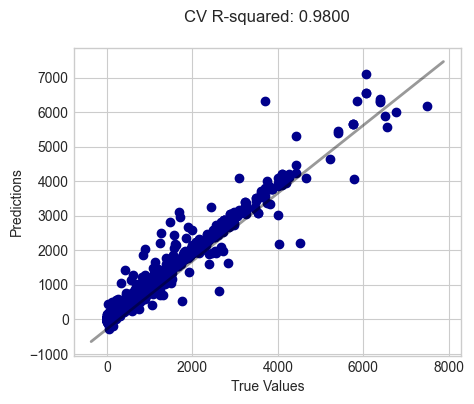

In [214]:
# XGBr Regressor for puts
pipe_xgb = Pipeline([('xgb', xg.XGBRegressor())])
param_xgb = {'xgb__max_depth':[3,4,5], 'xgb__min_child_weight':[4,5,6], 'xgb__gamma': [0.001, 0.01, 0.1], 'xgb__subsample':[0.6,0.7,0.8], 'xgb__colsample_bytree':[1]}
model(pipe_xgb, param_xgb, X_train_puts, y_train_puts, X_test_puts, y_test_puts, 'xgboost')

Best Param: {'xgb__colsample_bytree': 1, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__min_child_weight': 3, 'xgb__subsample': 0.8}


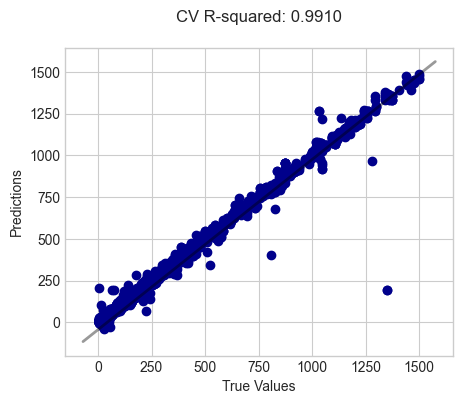

In [288]:
# XGBr Regressor for calls
pipe_xgb = Pipeline([('xgb', xg.XGBRegressor())])
param_xgb = {'xgb__max_depth':[3,4,5], 'xgb__min_child_weight':[3,4,5,6, 7, 8], 'xgb__gamma': [0.001,0.005, 0.01, 0.05, 0.1], 'xgb__subsample':[0.5,0.6,0.7,0.8,0.9], 'xgb__colsample_bytree':[1]}
model(pipe_xgb, param_xgb, X_train_calls, y_train_calls, X_test_calls, y_test_calls, 'xgboost')

Best Param: {'dt__max_depth': 24, 'dt__min_samples_leaf': 1}


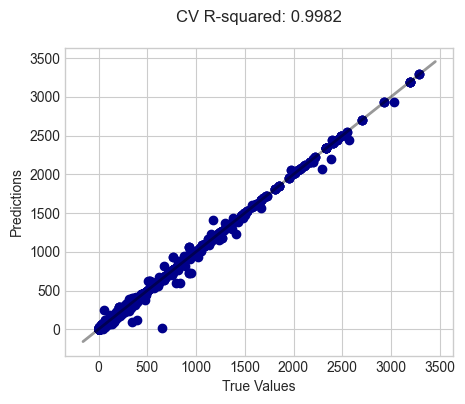

In [262]:
#DTR for puts
pipe_tree = Pipeline([('dt', DecisionTreeRegressor())])
param_tree = {'dt__max_depth': range(10,30), 'dt__min_samples_leaf': range(1,20)}
model(pipe_tree, param_tree, X_train_puts, y_train_puts, X_test_puts, y_test_puts, 'tree')

Best Param: {'dt__max_depth': 27, 'dt__min_samples_leaf': 1}


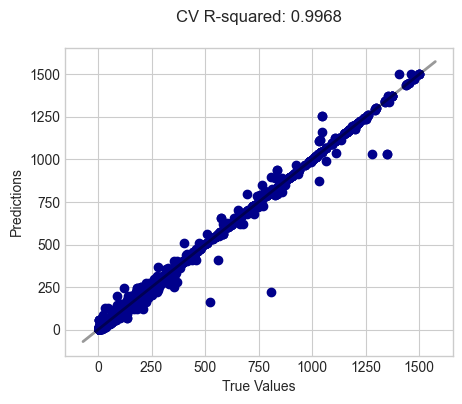

In [282]:
#DTR for calls
pipe_tree = Pipeline([('dt', DecisionTreeRegressor())])
param_tree = {'dt__max_depth': range(10,30), 'dt__min_samples_leaf': range(1,20)}
model(pipe_tree, param_tree, X_train_calls, y_train_calls, X_test_calls, y_test_calls, 'tree')

In [292]:
# XGBr for American call options
XGBr = xg.XGBRegressor(learning_rate=0.1, n_estimators=900)
cvs_XGBr = cross_val_score(XGBr, X_train_calls, y_train_calls, scoring='neg_root_mean_squared_error', cv=KFold(n_splits=10))
XGBr_score = cvs_XGBr.mean()
print(XGBr_score)

-5.730392124898603


In [293]:
XGBr = xg.XGBRegressor(learning_rate=0.02, colsample_bytree=1, gamma=0.001, max_depth=5, min_child_weight=3, subsample=0.8, n_estimators=900)
XGBr.fit(X_train_calls, y_train_calls)
XGBr_pred = XGBr.predict(X_test_calls)
XGBr_rmse = np.sqrt(mean_squared_error(y_test_calls, XGBr_pred))
XGBr_rmse
# Best Param: {'xgb__colsample_bytree': 1, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__min_child_weight': 3, 'xgb__subsample': 0.8}

9.109604706780216

In [244]:
# Save the trained model to a file
filename = 'XGBr_model_calls.sav'
pickle.dump(XGBr, open(filename, 'wb'))

In [298]:
y_pred = pd.DataFrame(XGBr_pred, columns=['prediction'])
final_test = pd.DataFrame(y_test_calls, columns=['real'])

final_df = pd.concat((final_test, y_pred), axis=1)
final_df

,real,prediction
0,18.25,10.733305
1,74.20,206.514450
2,125.06,20.745380
3,10.05,154.247452
4,10.05,40.213276
...,...,...
9058,317.00,NaN
9059,182.60,NaN
9060,21.38,NaN
9061,460.00,NaN


In [294]:
# XGBr for American puts options
XGBr = xg.XGBRegressor(learning_rate=0.05, colsample_bytree=1, gamma=0.001, max_depth=5, min_child_weight=4, subsample=0.07, n_estimators=900)
cvs_XGBr = cross_val_score(XGBr, X_train_puts, y_train_puts, scoring='neg_root_mean_squared_error', cv=KFold(n_splits=10))
XGBr_score = cvs_XGBr.mean()
print(XGBr_score)


-16.43855461271371


In [296]:
XGBr = xg.XGBRegressor(learning_rate=0.2, colsample_bytree=1, gamma=0.001, max_depth=5, min_child_weight=4, subsample=0.07, n_estimators=900)
XGBr.fit(X_train_puts, y_train_puts)
XGBr_pred = XGBr.predict(X_test_puts)
XGBr_rmse = np.sqrt(mean_squared_error(y_test_puts, XGBr_pred))
XGBr_rmse

12.316310762620752

In [261]:
# Save the trained model to a file
filename = 'XGBr_model_puts.sav'
pickle.dump(XGBr, open(filename, 'wb'))

In [14]:
y_pred = pd.DataFrame(XGBr_pred, columns=['prediction'])
final_test = pd.DataFrame(y_test_puts, columns=['real'])

final_df = pd.concat((final_test, y_pred), axis=1)
final_df

,real,prediction
0,283.68,284.167297
1,125.32,124.984299
2,6.25,6.190952
3,43.00,43.269341
4,482.70,482.800018
...,...,...
6060,71.10,69.383018
6061,22.30,22.238087
6062,15.90,15.990765
6063,13.05,12.976566


In [286]:
DTR_calls = DecisionTreeRegressor(max_depth=27, min_samples_leaf=1)
# cvs_DTR = cross_val_score(DTR, df_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
# DTR_score = cvs_DTR.mean()
# print(DTR_score)

DTR_calls.fit(X_train_calls, y_train_calls)
DTR1_pred = DTR_calls.predict(X_test_calls)
DTR1_rmse = np.sqrt(mean_squared_error(y_test_calls, DTR1_pred))
DTR1_rmse
# Best Param: {'dt__max_depth': 27, 'dt__min_samples_leaf': 1}

2.6362978109603987

In [287]:
y_pred = pd.DataFrame(DTR1_pred, columns=['prediction'])
final_test = pd.DataFrame(y_test_calls, columns=['real'])

final_df = pd.concat((final_test, y_pred), axis=1)
final_df

,real,prediction
0,18.25,18.25
1,74.20,74.20
2,125.06,125.06
3,10.05,10.05
4,10.05,10.05
...,...,...
9058,317.00,317.00
9059,182.60,182.60
9060,21.38,21.38
9061,460.00,460.00


In [52]:
# Save the trained model to a file
filename = 'DTR_model_calls.sav'
pickle.dump(DTR_calls, open(filename, 'wb'))

In [281]:
DTR_puts = DecisionTreeRegressor(max_depth=24, min_samples_leaf=1)
# cvs_DTR = cross_val_score(DTR, df_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
# DTR_score = cvs_DTR.mean()
# print(DTR_score)

DTR_puts.fit(X_train_puts, y_train_puts)
DTR1_pred = DTR_puts.predict(X_test_puts)
DTR1_rmse = np.sqrt(mean_squared_error(y_test_puts, DTR1_pred))
DTR1_rmse
# Best Param: {'dt__max_depth': 24, 'dt__min_samples_leaf': 1}

6.488836372500458

In [47]:
y_pred = pd.DataFrame(DTR1_pred, columns=['prediction'])
final_test = pd.DataFrame(y_test_puts, columns=['real'])

final_df = pd.concat((final_test, y_pred), axis=1)
final_df

,real,prediction
0,283.68,283.68
1,125.32,120.67
2,6.25,6.25
3,43.00,43.00
4,482.70,482.70
...,...,...
6060,71.10,71.10
6061,22.30,22.30
6062,15.90,15.90
6063,13.05,13.05


In [48]:
# Save the trained model to a file
filename = 'DTR_model_puts.sav'
pickle.dump(DTR_puts, open(filename, 'wb'))

### EU options

In [69]:
df = ML.getdata(True)

def modifydata(df):
    data_calls = []
    data_puts = []
    df_puts = df[df.optionType == 0].drop(columns='optionType')
    df_calls = df[df.optionType == 1].drop(columns='optionType')
    df_eu_calls = df_calls[df_calls.method == 0].drop(columns='method')
    df_eu_puts = df_puts[df_puts.method == 0].drop(columns='method')
    df_eu_calls = df_eu_calls.drop(columns='index')
    df_eu_calls = df_eu_calls[df_eu_calls.lastPrice > 5]
    df_eu_puts = df_eu_puts[df_eu_puts.lastPrice > 5]
    df_eu_puts = df_eu_puts.drop(columns='index')
    y_calls = np.asarray(df_eu_calls[['lastPrice']])
    y_puts = np.asarray(df_eu_puts[['lastPrice']])
    df_eu_calls = df_eu_calls.drop(columns='lastPrice')
    df_eu_puts = df_eu_puts.drop(columns='lastPrice')

    for line in range(len(df_eu_calls)):
        data_tmp = df_eu_calls.iloc[line]
        data_calls.append(data_tmp)
    data_calls = np.asarray(data_calls)


    for line in range(len(df_eu_puts)):
        data_tmp = df_eu_puts.iloc[line]
        data_puts.append(data_tmp)
    data_puts = np.asarray(data_puts)

    return data_calls, data_puts, y_calls, y_puts

In [84]:
X_calls, X_puts, y_calls, y_puts = modifydata(df)
X_train_calls, X_test_calls, y_train_calls, y_test_calls = train_test_split(X_calls, y_calls, test_size=0.25)
X_train_puts, X_test_puts, y_train_puts, y_test_puts = train_test_split(X_puts, y_puts, test_size=0.25)

In [85]:
print(X_test_calls.shape)
print(X_train_calls.shape)
print(X_test_puts.shape)
print(X_train_puts.shape)

(14403, 5)
(43209, 5)
(12856, 5)
(38565, 5)


In [202]:
# XGBr for European call options
XGBr_eu_calls = xg.XGBRegressor(learning_rate=0.1, colsample_bytree= 1, gamma= 0.001, max_depth= 5, min_child_weight= 4, subsample= 0.7, n_estimators=900)
cvs_XGBr = cross_val_score(XGBr, X_train_calls, y_train_calls, scoring='neg_root_mean_squared_error', cv=KFold(n_splits=10))
XGBr_score = cvs_XGBr.mean()
print(XGBr_score)

-43.93321704710112


In [206]:
XGBr_eu_calls = xg.XGBRegressor(learning_rate=0.1, colsample_bytree= 1, gamma= 0.001, max_depth= 5, min_child_weight= 4, subsample= 0.7, n_estimators=900)
XGBr_eu_calls.fit(X_train_calls, y_train_calls)
XGBr_pred = XGBr_eu_calls.predict(X_test_calls)
XGBr_rmse = np.sqrt(mean_squared_error(y_test_calls, XGBr_pred))
XGBr_rmse

74.7224953351218

In [168]:
# XGBr for European call options
XGBr_eu_puts = xg.XGBRegressor(learning_rate=0.1, n_estimators=900)
cvs_XGBr = cross_val_score(XGBr, X_train_puts, y_train_puts, scoring='neg_root_mean_squared_error', cv=KFold(n_splits=10))
XGBr_score = cvs_XGBr.mean()
print(XGBr_score)

-41.43701782995156


In [201]:

XGBr_eu_puts = xg.XGBRegressor(learning_rate=0.1, colsample_bytree= 1, gamma= 0.001, max_depth= 5, min_child_weight= 4, subsample= 0.7, n_estimators=800)
XGBr_eu_puts.fit(X_train_puts, y_train_puts)
XGBr_pred = XGBr_eu_puts.predict(X_test_puts)
XGBr_rmse = np.sqrt(mean_squared_error(y_test_puts, XGBr_pred))
error.append(XGBr_rmse)
XGBr_rmse



27.985915046769126

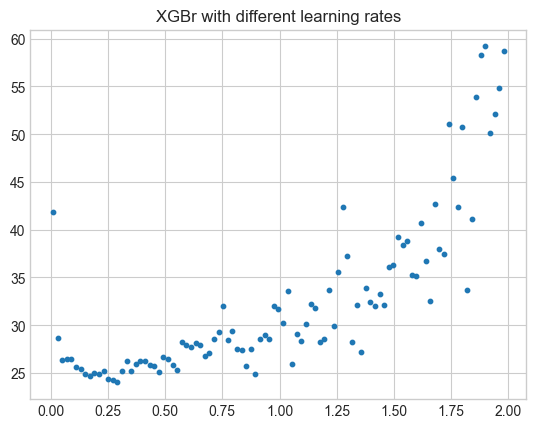

In [121]:
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
plt.scatter(alpha_array[:-1], error[:-1], s=10)
plt.title('XGBr with different learning rates')
plt.savefig('./Presentation files/XGBr_Calibration.png')


In [212]:
# Save the trained model to a file
filename = 'XGBr_eu_puts.sav'
pickle.dump(XGBr_eu_puts, open(filename, 'wb'))
filename = 'XGBr_eu_calls.sav'
pickle.dump(XGBr_eu_calls, open(filename, 'wb'))

In [210]:
DTR_calls = DecisionTreeRegressor(max_depth=24, min_samples_leaf=1)
# cvs_DTR = cross_val_score(DTR, df_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
# DTR_score = cvs_DTR.mean()
# print(DTR_score)

DTR_calls.fit(X_train_calls, y_train_calls)
DTR1_pred = DTR_calls.predict(X_test_calls)
DTR1_rmse = np.sqrt(mean_squared_error(y_test_calls, DTR1_pred))
DTR1_rmse

99.6828650937288

In [177]:
def model(pipeline, parameters, X_train, y_train, X, y, figname):
    grid_obj = GridSearchCV(estimator = pipeline, param_grid = parameters, cv = 5, scoring = 'r2', verbose = 0, n_jobs = 1, refit = True)
    grid_obj.fit(X_train, y_train)

    print("Best Param:", grid_obj.best_params_)
    estimator = grid_obj.best_estimator_
    shuffle = KFold(n_splits = 5, shuffle = True, random_state = 0)
    cv_scores = cross_val_score(estimator, X, y.ravel(), cv=shuffle, scoring='r2')

    y_pred = cross_val_predict(estimator, X, y, cv = shuffle)
    plt.figure(figsize = (5,4))
    plt.scatter(y, y_pred, color = "darkblue")
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.plot([xmin, xmax], [ymin, ymax], "black", lw = 2, alpha = 0.4)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title('CV R-squared: {:.4f}\n'.format(float(cv_scores.mean())), size = 12)
    plt.show()








Best Param: {'dt__max_depth': 21, 'dt__min_samples_leaf': 1}


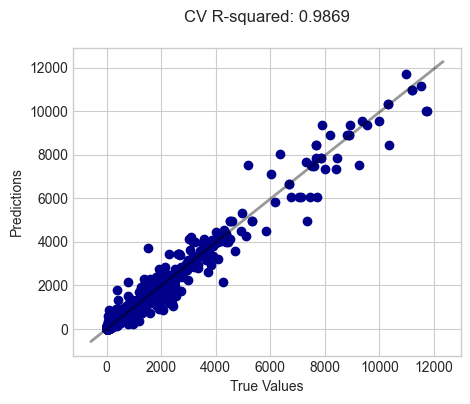

In [178]:
#DTR for calls
pipe_tree = Pipeline([('dt', DecisionTreeRegressor())])
param_tree = {'dt__max_depth': range(10,30), 'dt__min_samples_leaf': range(1,20)}
model(pipe_tree, param_tree, X_train_calls, y_train_calls, X_test_calls, y_test_calls, 'tree')

In [184]:
DTR_puts = DecisionTreeRegressor(max_depth=22, min_samples_leaf=1)
# cvs_DTR = cross_val_score(DTR, df_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
# DTR_score = cvs_DTR.mean()
# print(DTR_score)

DTR_puts.fit(X_train_puts, y_train_puts)
DTR1_pred = DTR_puts.predict(X_test_puts)
DTR1_rmse = np.sqrt(mean_squared_error(y_test_puts, DTR1_pred))
DTR1_rmse

19.33815293308031

Best Param: {'dt__max_depth': 22, 'dt__min_samples_leaf': 1}


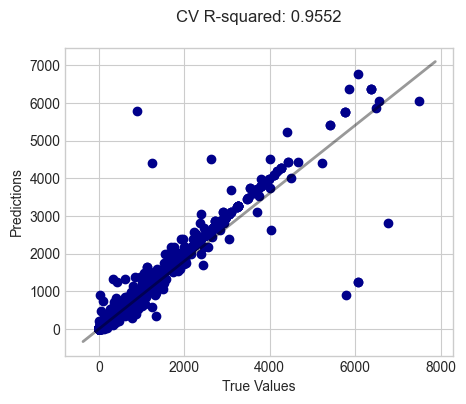

In [185]:
#DTR for puts
pipe_tree = Pipeline([('dt', DecisionTreeRegressor())])
param_tree = {'dt__max_depth': range(10,30), 'dt__min_samples_leaf': range(1,20)}
model(pipe_tree, param_tree, X_train_puts, y_train_puts, X_test_puts, y_test_puts, 'tree')

Best Param: {'xgb__colsample_bytree': 1, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__min_child_weight': 6, 'xgb__subsample': 0.8}


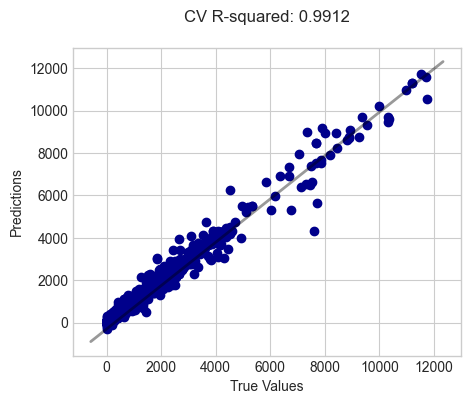

In [166]:
# XGBr Regressor for calls
pipe_xgb = Pipeline([('xgb', xg.XGBRegressor())])
param_xgb = {'xgb__max_depth':[3,4,5], 'xgb__min_child_weight':[4,5,6], 'xgb__gamma': [0.001, 0.01, 0.1], 'xgb__subsample':[0.6,0.7,0.8], 'xgb__colsample_bytree':[1]}
model(pipe_xgb, param_xgb, X_train_calls, y_train_calls, X_test_calls, y_test_calls, 'xgboost')

Best Param: {'xgb__colsample_bytree': 1, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__min_child_weight': 4, 'xgb__subsample': 0.7}


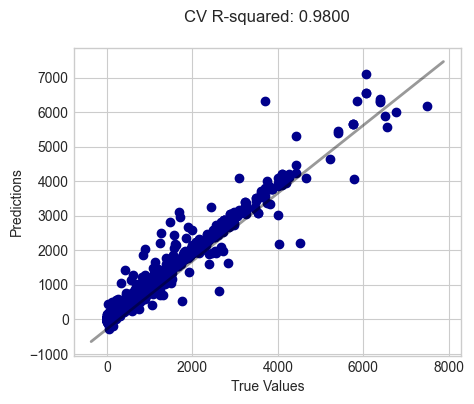

In [195]:
# XGBr Regressor for puts
pipe_xgb = Pipeline([('xgb', xg.XGBRegressor())])
param_xgb = {'xgb__max_depth':[3,4,5], 'xgb__min_child_weight':[4,5,6], 'xgb__gamma': [0.001, 0.01, 0.1], 'xgb__subsample':[0.6,0.7,0.8], 'xgb__colsample_bytree':[1]}
model(pipe_xgb, param_xgb, X_train_puts, y_train_puts, X_test_puts, y_test_puts, 'xgboost')

In [211]:
# Save the trained model to a file
filename = 'DTR_eu_puts.sav'
pickle.dump(DTR_puts, open(filename, 'wb'))
# Save the trained model to a file
filename = 'DTR_eu_calls.sav'
pickle.dump(DTR_calls, open(filename, 'wb'))